In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/Users/ishanjoshi/Customer Segmentation Analysis/customer_shopping_data.csv')

In [9]:
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [15]:
df['shopping_mall'].value_counts()

shopping_mall
Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: count, dtype: int64

In [17]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

In [27]:
df.tail(5)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,21/09/2022,Kanyon
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,22/09/2021,Forum Istanbul
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,28/03/2021,Metrocity
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,16/03/2021,Istinye Park
99456,I232867,C273973,Female,36,Souvenir,3,35.19,Credit Card,15/10/2022,Mall of Istanbul


In [52]:
#Recency

day = df['invoice_date'].max()

# Recalculating recency based on the actual range in the dataset (2021-2023)
recency = df.groupby(["customer_id"]).agg({"invoice_date": lambda x: (day - x.max()).days})

# Displaying the first few records of recency
recency.head(10)

,invoice_date
customer_id,
C100004,467
C100005,5
C100006,97
C100012,570
C100019,591
C100025,643
C100028,468
C100030,146
C100034,579


In [54]:
#Frequency

freq=df.drop_duplicates(subset="invoice_no").groupby(["customer_id"])[["invoice_no"]].count()
freq.head(10)

,invoice_no
customer_id,
C100004,1
C100005,1
C100006,1
C100012,1
C100019,1
C100025,1
C100028,1
C100030,1
C100034,1


In [74]:
#Monetary

df["total"]=df["quantity"]*df["price"]

In [76]:
money=df.groupby(["customer_id"])[["total"]].sum()
money

,total
customer_id,
C100004,7502.00
C100005,2400.68
C100006,322.56
C100012,130.75
C100019,35.84
...,...
C999886,47.07
C999910,136.35
C999974,7502.00


In [80]:
RFM=pd.concat([recency,freq,money], axis=1)
recency.columns=["Recency"]
freq.columns=["Frequency"]
money.columns=["Monetary"]
RFM

,Recency,Frequency,Monetary
customer_id,,,
C100004,467,1,7502.00
C100005,5,1,2400.68
C100006,97,1,322.56
C100012,570,1,130.75
C100019,591,1,35.84
...,...,...,...
C999886,0,1,47.07
C999910,123,1,136.35
C999974,302,1,7502.00


In [82]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

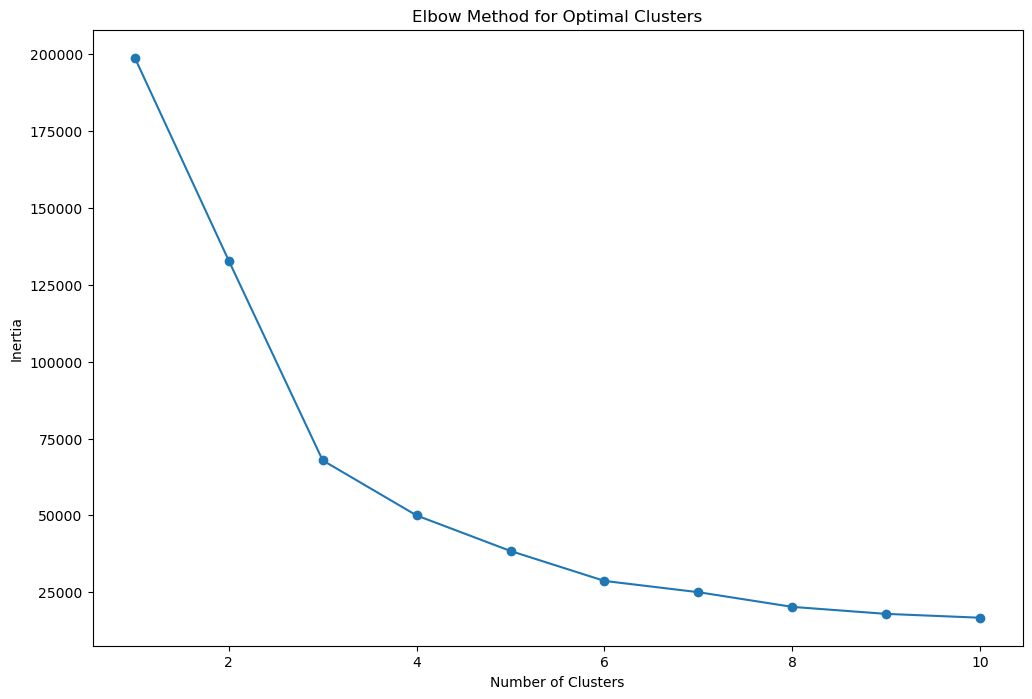

In [84]:
inertia = []

# Loop to calculate inertia for different cluster numbers
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

# Plotting the inertia values
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertia, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [86]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Clusters"]=(kmeans.labels_+1)

In [88]:
RFM

,Recency,Frequency,Monetary,Clusters
customer_id,,,,
C100004,467,1,7502.00,3
C100005,5,1,2400.68,1
C100006,97,1,322.56,1
C100012,570,1,130.75,2
C100019,591,1,35.84,2
...,...,...,...,...
C999886,0,1,47.07,1
C999910,123,1,136.35,1
C999974,302,1,7502.00,3


In [92]:
final = RFM.groupby("Clusters")[["Recency", "Frequency", "Monetary"]].mean()
final

,Recency,Frequency,Monetary
Clusters,,,
1,195.290956,1.0,1292.27976
2,600.722255,1.0,1359.13751
3,389.333480,1.0,11843.14996


In [94]:
def func(row):
    if row["Clusters"]==1:
        return 'Whales'
    elif row["Clusters"]==2:
        return 'Lapsed Cx'
    else:
        return 'Avg. Cx'

In [96]:
RFM['group']=RFM.apply(func, axis=1)

In [98]:
RFM

,Recency,Frequency,Monetary,Clusters,group
customer_id,,,,,
C100004,467,1,7502.00,3,Avg. Cx
C100005,5,1,2400.68,1,Whales
C100006,97,1,322.56,1,Whales
C100012,570,1,130.75,2,Lapsed Cx
C100019,591,1,35.84,2,Lapsed Cx
...,...,...,...,...,...
C999886,0,1,47.07,1,Whales
C999910,123,1,136.35,1,Whales
C999974,302,1,7502.00,3,Avg. Cx


In [100]:
result=RFM.group.value_counts()

In [102]:
result

group
Whales       44072
Lapsed Cx    44008
Avg. Cx      11377
Name: count, dtype: int64

<Axes: ylabel='group'>

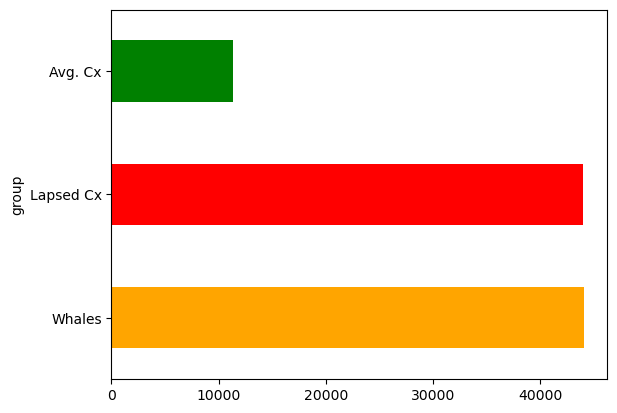

In [111]:
result.plot(kind="barh", color=["Orange","Red","Green"])